In [1]:
#Importing the necessary modules
from wise_light_curves.wise_light_curves import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
from astropy.io import ascii
from astropy.io import fits
import numpy as np
import pandas as pd
import os
import scipy
from Potato import plotparams
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import constants as const
#End of Importing

In [2]:
#This is where the asassnid goes
id = 42950993887																																																																												

ra_val = 306.0094122			

dec_val = 38.66055087														

cust_id = 'J202402+383938'

# 			

In [3]:
#Defining the read_lightcurve function. This function reads data files and imports them
def read_lightcurve(asas_sn_id, guide = 'known_dipper_lightcurves/'):
    """
    Input: 
        asas_sn_id: the asassn id of the desired star
        guide: the path to the data file of the desired star

    Output: 
        dfv: This is the dataframe for the V-band data of the star
        dfg: This is the dataframe for the g-band data of the star
    
    This function reads the data of the desired star by going to the corresponding file and copying the data of that file onto 
    a data frame. This data frame is then sorted into two data frames by comparing the value in the Photo filter column. If the
    Photo filter column data has a value of one, its row is sorted into the data frame corresponding to the V-band. If the Photo
    filter column data has a value of zero, it gets sorted into the data frame corresponding to the g-band.
    """
    fname = os.path.join(guide, str(asas_sn_id)+'.dat')

    dfv = pd.DataFrame()
    dfg = pd.DataFrame()

    fdata = pd.read_fwf(fname, header=None)
    fdata.columns = ["JD", "Mag", "Mag_err", "Quality", "Cam_number", "Phot_filter", "Camera"] #These are the columns of data

    dfv = fdata.loc[fdata["Phot_filter"] == 1].reset_index(drop=True) #This sorts the data into the V-band
    dfg = fdata.loc[fdata["Phot_filter"] == 0].reset_index(drop=True) #This sorts the data into the g-band

    return dfv, dfg
#End of read_lightcurve function

In [4]:
dfv, dfg = read_lightcurve(id, 'Updated_LC_data/')

dfg['Mag'] = [float(i) for i in dfg['Mag']]

dfg['JD'] = [float(i) for i in dfg['JD']]

mag = dfg['Mag']

jd = dfg['JD']

meanmag = sum(mag) / len(mag)

dfg_mag_avg = [i - meanmag for i in mag]

peaks = scipy.signal.find_peaks(dfg_mag_avg, prominence=0.17, distance=25, height=0.3, width=2) 

peak = peaks[0]

prop = peaks[1]

length = len(peak)

peak = [int(i) for i in peak]

peak = pd.Series(peak)

In [5]:
print('The mean magnitude of the whole light curve:', meanmag)

c = SkyCoord(ra=ra_val*u.degree, dec=dec_val*u.degree, frame='icrs')
print(c.ra.hms)
print(c.dec.dms)

The mean magnitude of the whole light curve: 13.114327826934804
hms_tuple(h=20.0, m=24.0, s=2.2589280000153167)
dms_tuple(d=38.0, m=39.0, s=37.98313200000564)


In [6]:
fnames = [ f for f in os.listdir(str(id)) if f.startswith('apVisit') ]

print(fnames)

dfs_apogee = []
jds_apogee = []

for f in fnames:
    
    hdul = fits.open(str(id)+'/'+f)
    jds_apogee.append(hdul[0].header['JD-MID'])
    
    wavelengths = np.concatenate([hdul[4].data[i,:] for i in range(hdul[1].data.shape[0]) ])
    fluxes = np.concatenate([hdul[1].data[i,:] for i in range(hdul[1].data.shape[0])])
    df_spec = pd.DataFrame({'wavelength': wavelengths, 'flux':fluxes}).sort_values(by='wavelength')
    df_spec = df_spec.reset_index(drop=True)
    
    dfs_apogee.append(df_spec)

['apVisit-dr17-11415-58637-040.fits', 'apVisit-dr17-11415-58732-046.fits', 'apVisit-dr17-12765-59147-207.fits', 'apVisit-dr17-11415-58642-040.fits', 'apVisit-dr17-12765-59154-207.fits', 'apVisit-dr17-12765-59155-207.fits', 'apVisit-dr17-12766-59156-254.fits', 'apVisit-dr17-12764-59146-262.fits']


Text(0.5, 1.0, 'J202402+383938')

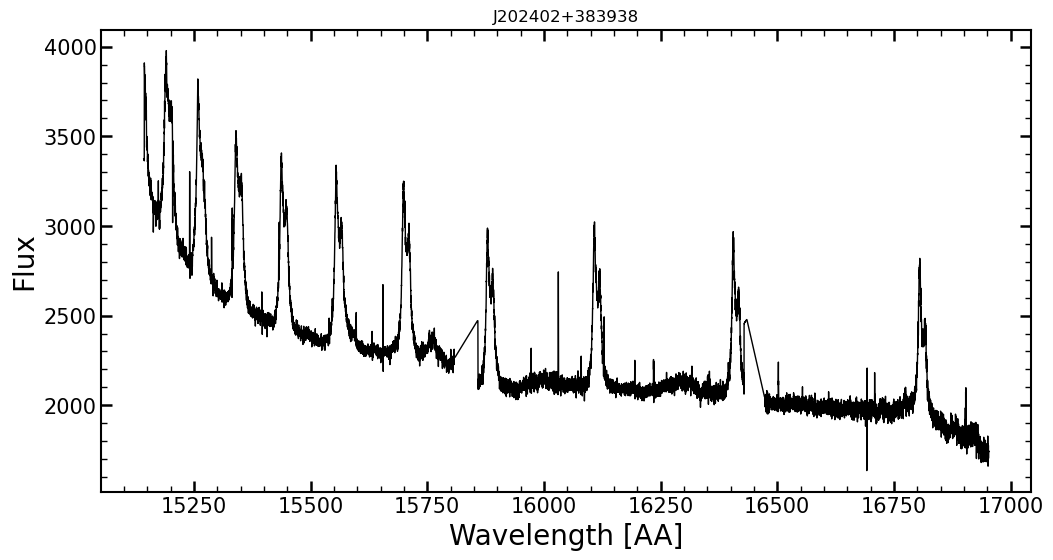

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)

ax.plot(dfs_apogee[0].wavelength, dfs_apogee[0].flux, color='black', lw=1)
ax.set_xlabel('Wavelength [AA]', fontsize=20)
ax.set_ylabel('Flux', fontsize=20)
plt.title(cust_id)

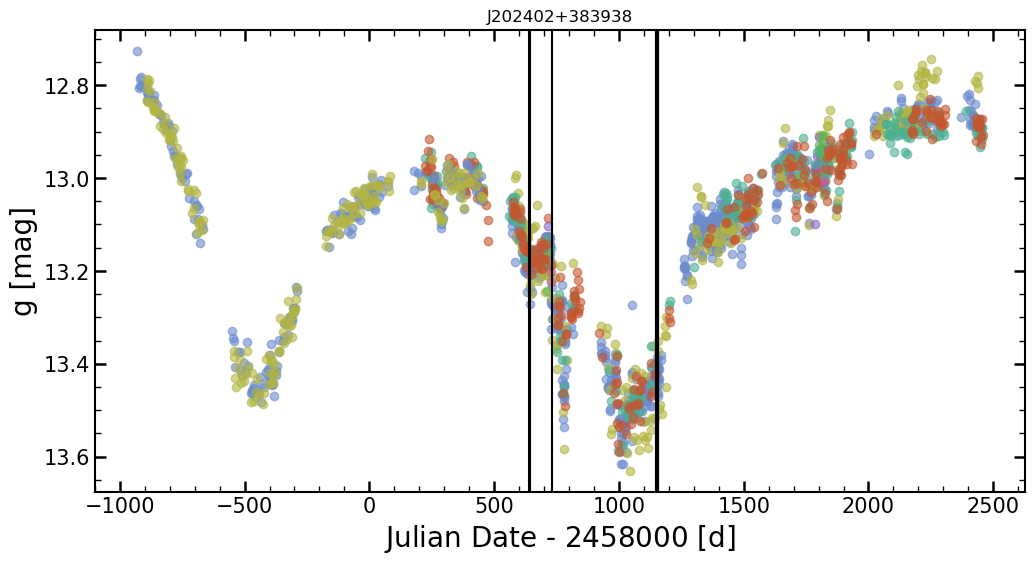

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax = plotparams(ax)
ax.set_title(cust_id)

cams = dfg["Camera"]
camtype = np.unique(cams)
camnum = len(camtype)

cams2 = dfv["Camera"]
camtype2 = np.unique(cams2)
camnum2 = len(camtype2)

colors = ["#6b8bcd", "#b3b540", "#8f62ca", "#5eb550", "#c75d9c", "#4bb092", "#c5562f", "#6c7f39", 
              "#ce5761", "#c68c45", '#b5b246', '#d77fcc', '#7362cf', '#ce443f', '#3fc1bf', '#cda735',
              '#a1b055']
    
camdf = pd.DataFrame()

camdf2 = pd.DataFrame()

for i in range(0,camnum):
    camdf = dfg.loc[dfg["Camera"] == camtype[i]].reset_index(drop=True)
    for j in range(0,len(camdf)):
        camjd = [float(i) for i in camdf["JD"]]
        cammag = [float(i) for i in camdf['Mag']]
        ax.scatter((camjd[j] - (2.458 * 10 **6)), cammag[j], color = colors[i], alpha = 0.6)

for i in range(0,camnum2):
    camdf2 = dfv.loc[dfv["Camera"] == camtype2[i]].reset_index(drop=True)
    for j in range(0,len(camdf2)):
        camjd2 = [float(i) for i in camdf2["JD"]]
        cammag2 = [float(i) for i in camdf2['Mag']]
        ax.scatter((camjd2[j] - (2.458 * 10 **6)), cammag2[j], color = colors[i], alpha = 0.6)

for jd in jds_apogee:
    ax.axvline(jd - 2.458e6, color='black')

ax.invert_yaxis() 
ax.set_xlabel('Julian Date - $2458000$ [d]', fontsize=20)
ax.set_ylabel('g [mag]', fontsize=20)
plt.show()

In [9]:
#The apogee files arenot necessarily in order, so sort the spectra by time

df_master = pd.DataFrame({'JD':jds_apogee, 'spec':dfs_apogee})
df_master = df_master.sort_values(by='JD', ascending=True).reset_index(drop=True)
df_master

,JD,spec
0,2.458638e+06,wavelength flux 0 15142....
1,2.458643e+06,wavelength flux 0 15142....
2,2.458733e+06,wavelength flux 0 15142....
3,2.459147e+06,wavelength flux 0 15140....
4,2.459148e+06,wavelength flux 0 15140....
5,2.459155e+06,wavelength flux 0 15140....
6,2.459156e+06,wavelength flux 0 15140....
7,2.459157e+06,wavelength flux 0 15140....


In [10]:
spectrum_time = Time(df_master.JD[0], format='jd')
spectrum_time.format = 'iso'
print('The time the spectrum was taken:', spectrum_time)

latest_spectra = Time(df_master.JD[len(df_master)-1], format='jd')
latest_spectra.format = 'iso'
print('The time the most recent spectrum was taken', latest_spectra)

The time the spectrum was taken: 2019-06-03 10:52:21.792
The time the most recent spectrum was taken 2020-11-03 02:46:56.352


In [11]:
#You'll notice the spectra are really just clustered around three dates, so define idx of interest
idx = [0, 2, 3]

In [12]:
#The double-peaked lines in the spectrum are Brakett Hydrogen. 

#This is the ryberg formula
def brakett_wavelength(n):
    
    Rh = 1.09737e7 * u.Unit('m^-1')
    l_inv = Rh*( (1/4**2) - (1/n**2) )
    return (1/l_inv).to('AA').value

def plot_brakett_line(spec, n, ax=None, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        created_fig = True
    else:
        created_fig = False
        
    ll = brakett_wavelength(n)
    
    wavelength_range = (ll-50, ll+50) 
    
    idx = np.where( (spec.wavelength > wavelength_range[0]) &
                    (spec.wavelength < wavelength_range[1]))[0]
    
    spec = spec.copy().iloc[idx].reset_index(drop=True)
    ax.plot(spec.wavelength, spec.flux, **kwargs)
    
    ax.axvline(ll, color='black', ls='--')
    
    return ax

Text(0, 0.5, 'Flux')

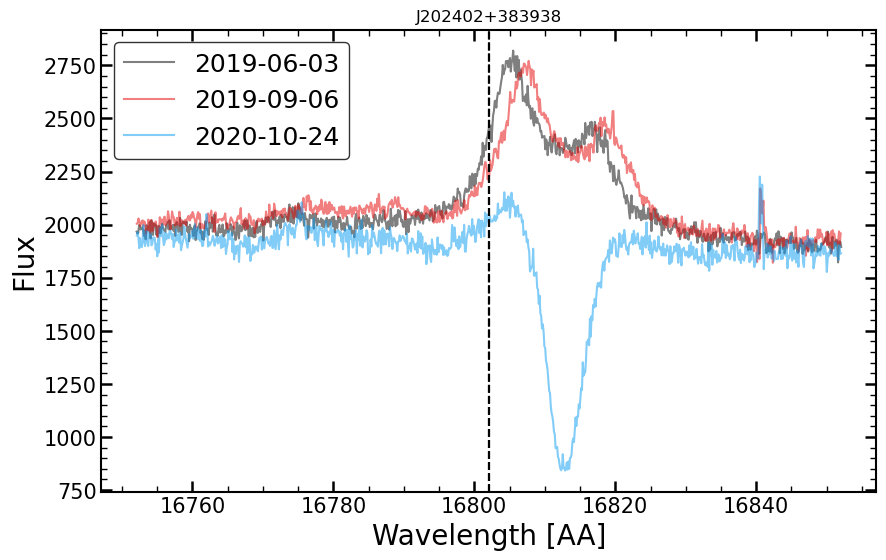

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = plotparams(ax)
ax.set_title(cust_id)

n = 11 #so n=15 to n=4 transition    20-11

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):    
    ax = plot_brakett_line(df_master.spec.iloc[i], n, ax=ax, color=color,
                      alpha=0.5,
                      label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))
    
ax.legend(loc='upper left', edgecolor='black', fontsize=18)

ax.set_xlabel('Wavelength [AA]', fontsize=20)
ax.set_ylabel('Flux', fontsize=20)

# J202402+383938_Spectra_n20

In [14]:
print(brakett_wavelength(19))

15256.503262807662


In [15]:
def Doppler_shift(df_master, i, n, r, rv):
    '''
    Inputs:
        df_master = the dataframe of all the spectra
        i = integer from 0 to number of total spectra -1; used to chose the specific spectra being shifted
        n = the energy level of the Brackett transition
        r = half of wavelength range
        rv = velocity shift
    '''
    df_spec = df_master.spec[i]

    ll = brakett_wavelength(n)

    wavelength_range = (ll-r, ll+r)
    idx = np.where( (df_spec.wavelength > wavelength_range[0]) & (df_spec.wavelength < wavelength_range[1]))[0]
    df_spec = df_spec.iloc[idx].reset_index(drop=True)

    c = 299792458.0 #speed of light m/s

    factor = 1 / (1 + (rv * 1000.) / c)

    shifted = np.interp(df_spec.wavelength,
                    df_spec.wavelength/factor,
                    df_spec.flux,
                    left=np.nan, right=np.nan)

    df_spec['flux'] = shifted
    df_spec = df_spec[~df_spec.flux.isna()].reset_index(drop=True)

    rest = ll*u.AA

    vel = const.c * (df_spec.wavelength.values*u.AA - rest) / rest
    vel = vel.to('km/s').value
    df_spec['vel'] = vel

    return df_spec

In [16]:
Doppler = Doppler_shift(df_master, 0, 19, 50, -170)
Doppler.head(10)

,wavelength,flux,vel
0,15206.661826,2934.247865,-979.391311
1,15206.832738,2934.838268,-976.032872
2,15207.003645,2910.280319,-972.674524
3,15207.174548,2912.965525,-969.316266
4,15207.345445,2909.768234,-965.958099
5,15207.516339,2898.461773,-962.600022
6,15207.687227,2912.992440,-959.242036
7,15207.858111,2886.720825,-955.884141
8,15208.028991,2889.972560,-952.526336
9,15208.199866,2924.141768,-949.168623


In [17]:
Spectra = dfs_apogee[0]

Spectra1 = Spectra.loc[Spectra.wavelength <= 15800].reset_index(drop=True)

Spectra2 = Spectra.loc[Spectra.wavelength >= 15860].reset_index(drop=True)
Spectra2 = Spectra2.loc[Spectra2.wavelength <= 16430].reset_index(drop=True)

Spectra3 = Spectra.loc[Spectra.wavelength >= 16475].reset_index(drop=True)


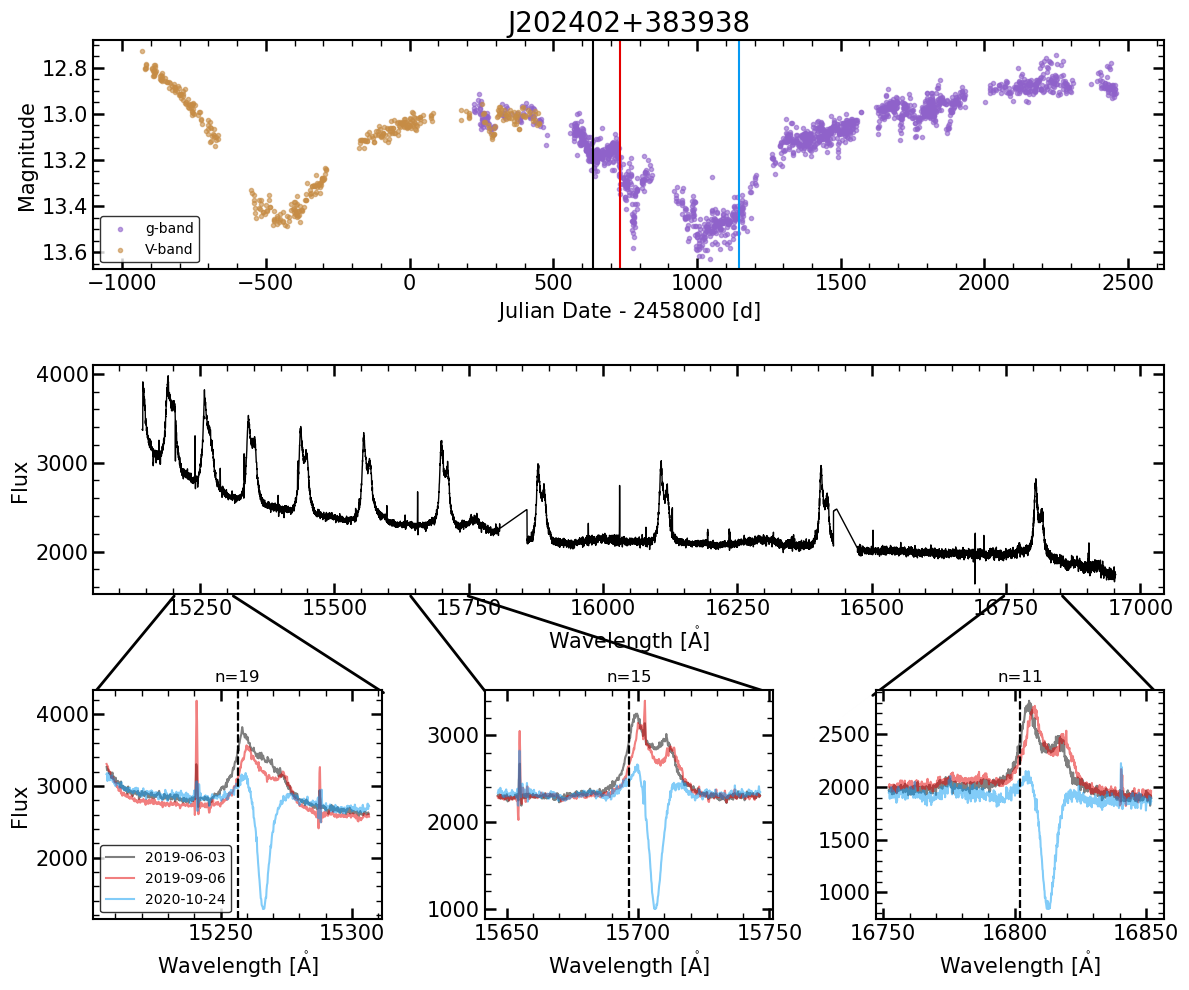

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
gs = ax[1, 2].get_gridspec()

#Subfig 1
for axs in ax[0, 0:]:
    axs.remove()

axbig = fig.add_subplot(gs[0, 0:])
axbig = plotparams(axbig)
axbig.set_title(cust_id, fontsize=20)

colors = ["#6b8bcd", "#b3b540", "#8f62ca", "#5eb550", "#c75d9c", "#4bb092", "#c5562f", "#6c7f39", 
              "#ce5761", "#c68c45", '#b5b246', '#d77fcc', '#7362cf', '#ce443f', '#3fc1bf', '#cda735',
              '#a1b055']

dfg_day = [i - (2.458 * 10**6) for i in dfg['JD']]

axbig.scatter(dfg_day, dfg['Mag'], color = colors[2], alpha = 0.6, label='g-band', marker='.')

dfv_day = [i - (2.458 * 10**6) for i in dfv['JD']]

axbig.scatter(dfv_day, dfv['Mag'], color = colors[9], alpha = 0.6, label='V-band', marker='.')

for jd, color in zip(jds_apogee, ['black', 'xkcd:red', 'xkcd:azure']):
    axbig.axvline(jd - 2.458e6, color=color)

axbig.invert_yaxis() 
axbig.set_xlabel('Julian Date - $2458000$ [d]', fontsize=15)
axbig.set_ylabel('Magnitude', fontsize=15)
axbig.legend(loc='lower left', edgecolor='black')

#Subfig 2
for axs in ax[1, 0:]:
    axs.remove()

axbig2 = fig.add_subplot(gs[1, 0:])
axbig2 = plotparams(axbig2)

axbig2.plot(dfs_apogee[0].wavelength, dfs_apogee[0].flux, color='black', lw=1)
axbig2.set_xlabel(r'Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=15)
axbig2.set_ylabel('Flux', fontsize=15)

#Subfig 3
ax[2, 0].remove()
axsmall1 = fig.add_subplot(gs[2, 0])
axsmall1 = plotparams(axsmall1)

n1 = 19

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):    
    axsmall1 = plot_brakett_line(df_master.spec.iloc[i], n1, ax=axsmall1, color=color,
                      alpha=0.5,
                      label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))
    
axsmall1.legend(loc='lower left', edgecolor='black')
axsmall1.set_title('n=19')
axsmall1.set_xlabel(r'Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=15)
axsmall1.set_ylabel('Flux', fontsize=15)

con1 = ConnectionPatch(xyA =(15202, 4300),
                      coordsA = axsmall1.transData,
                      xyB =(15202, 1500), 
                      coordsB = axbig2.transData)

con1.set_color([0, 0, 0])
con1.set_linewidth(2)
axbig2.add_artist(con1)

con2 = ConnectionPatch(xyA =(15312, 4300),
                      coordsA = axsmall1.transData,
                      xyB =(15312, 1500), 
                      coordsB = axbig2.transData)

con2.set_color([0, 0, 0])
con2.set_linewidth(2)
axbig2.add_artist(con2)

#Subfig 4
ax[2, 1].remove()
axsmall2 = fig.add_subplot(gs[2, 1])
axsmall2 = plotparams(axsmall2)

n2 = 15

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):    
    axsmall2 = plot_brakett_line(df_master.spec.iloc[i], n2, ax=axsmall2, color=color,
                      alpha=0.5,
                      label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))

axsmall2.set_xlabel(r'Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=15)
axsmall2.set_title('n=15')

con3 = ConnectionPatch(xyA =(15642, 3500),
                      coordsA = axsmall2.transData,
                      xyB =(15642, 1500), 
                      coordsB = axbig2.transData)

con3.set_color([0, 0, 0])
con3.set_linewidth(2)
axbig2.add_artist(con3)

con4 = ConnectionPatch(xyA =(15749, 3500),
                      coordsA = axsmall2.transData,
                      xyB =(15749, 1500), 
                      coordsB = axbig2.transData)

con4.set_color([0, 0, 0])
con4.set_linewidth(2)
axbig2.add_artist(con4)

#Subfig 5
ax[2, 2].remove()
axsmall3 = fig.add_subplot(gs[2, 2])
axsmall3 = plotparams(axsmall3)

n3 = 11

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):    
    axsmall3 = plot_brakett_line(df_master.spec.iloc[i], n3, ax=axsmall3, color=color,
                      alpha=0.5,
                      label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))

axsmall3.set_xlabel(r'Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=15)
axsmall3.set_title('n=11')

con5 = ConnectionPatch(xyA =(16746, 2870),
                      coordsA = axsmall3.transData,
                      xyB =(16746, 1500), 
                      coordsB = axbig2.transData)

con5.set_color([0, 0, 0])
con5.set_linewidth(2)
axbig2.add_artist(con5)

con6 = ConnectionPatch(xyA =(16855, 2870),
                      coordsA = axsmall3.transData,
                      xyB =(16855, 1500), 
                      coordsB = axbig2.transData)

con6.set_color([0, 0, 0])
con6.set_linewidth(2)
axbig2.add_artist(con6)

fig.tight_layout()
plt.show()

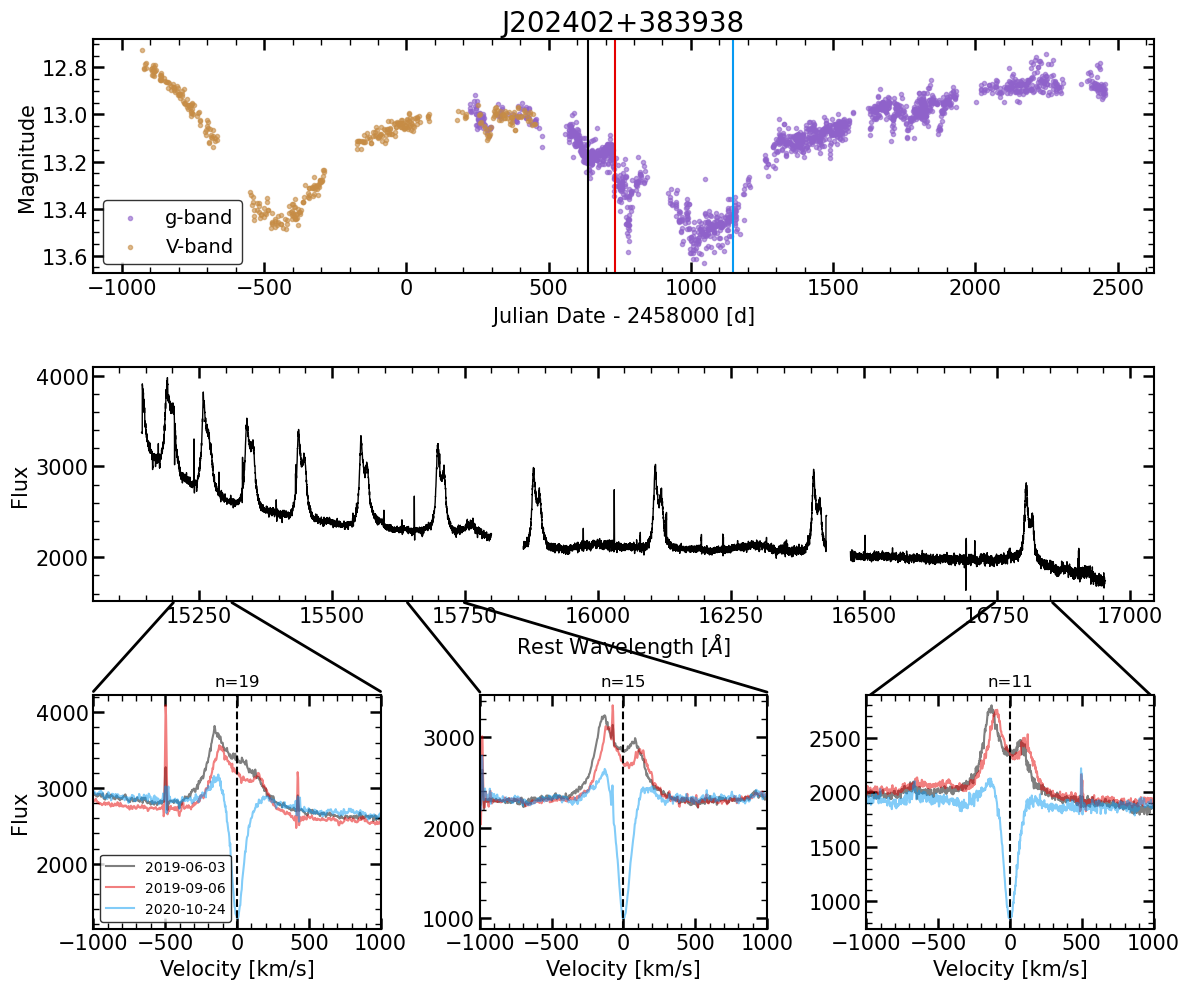

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
gs = ax[1, 2].get_gridspec()

v = -190

l = 75

#Subfig 1
for axs in ax[0, 0:]:
    axs.remove()

axbig = fig.add_subplot(gs[0, 0:])
axbig = plotparams(axbig)
axbig.set_title(cust_id, fontsize=20)

colors = ["#6b8bcd", "#b3b540", "#8f62ca", "#5eb550", "#c75d9c", "#4bb092", "#c5562f", "#6c7f39", 
              "#ce5761", "#c68c45", '#b5b246', '#d77fcc', '#7362cf', '#ce443f', '#3fc1bf', '#cda735',
              '#a1b055']

dfg_day = [i - (2.458 * 10**6) for i in dfg['JD']]

axbig.scatter(dfg_day, dfg['Mag'], color = colors[2], alpha = 0.6, label='g-band', marker='.')

dfv_day = [i - (2.458 * 10**6) for i in dfv['JD']]

axbig.scatter(dfv_day, dfv['Mag'], color = colors[9], alpha = 0.6, label='V-band', marker='.')

for jd, color in zip(jds_apogee, ['black', 'xkcd:red', 'xkcd:azure']):
    axbig.axvline(jd - 2.458e6, color=color)

axbig.invert_yaxis() 
axbig.set_xlabel('Julian Date - $2458000$ [d]', fontsize=15)
axbig.set_ylabel('Magnitude', fontsize=15)
axbig.legend(loc='lower left', edgecolor='black', fontsize=14)

#Subfig 2
for axs in ax[1, 0:]:
    axs.remove()

axbig2 = fig.add_subplot(gs[1, 0:])
axbig2 = plotparams(axbig2)

axbig2.plot(Spectra1.wavelength, Spectra1.flux, color='black', lw=1)
axbig2.plot(Spectra2.wavelength, Spectra2.flux, color='black', lw=1)
axbig2.plot(Spectra3.wavelength, Spectra3.flux, color='black', lw=1)
#axbig2.set_xlabel(r'Rest Wavelength [{}]'.format(f'{u.AA:latex}'), fontsize=15)
axbig2.set_xlabel('Rest Wavelength [$\AA{}$]', fontsize=15)
axbig2.set_ylabel('Flux', fontsize=15)

#Subfig 3
ax[2, 0].remove()
axsmall1 = fig.add_subplot(gs[2, 0])
axsmall1 = plotparams(axsmall1)

n1 = 19

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):
    Subfig3 = Doppler_shift(df_master, i, n1, l, v)
    axsmall1.plot(Subfig3.vel, Subfig3.flux, color=color, alpha=0.5,
                    label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))

axsmall1.axvline(0, color='black', ls='--')

axsmall1.set_xlim(-1000,1000)
axsmall1.legend(loc='lower left', edgecolor='black')
axsmall1.set_title('n=19')
#axsmall1.set_xlabel(r'Velocity [{}]'.format(f'{u.km/u.s:latex}'), fontsize=15)
axsmall1.set_xlabel('Velocity [km/s]', fontsize=15)
axsmall1.set_ylabel('Flux', fontsize=15)

con1 = ConnectionPatch(xyA =(-1000, 4275),
                      coordsA = axsmall1.transData,
                      xyB =(15202, 1500), 
                      coordsB = axbig2.transData)

con1.set_color([0, 0, 0])
con1.set_linewidth(2)
axbig2.add_artist(con1)

con2 = ConnectionPatch(xyA =(1000, 4275),
                      coordsA = axsmall1.transData,
                      xyB =(15312, 1500), 
                      coordsB = axbig2.transData)

con2.set_color([0, 0, 0])
con2.set_linewidth(2)
axbig2.add_artist(con2)

#Subfig 4
ax[2, 1].remove()
axsmall2 = fig.add_subplot(gs[2, 1])
axsmall2 = plotparams(axsmall2)

n2 = 15

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):
    Subfig4 = Doppler_shift(df_master, i, n2, l, v)
    axsmall2.plot(Subfig4.vel, Subfig4.flux, color=color, alpha=0.5,
                    label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))

axsmall2.axvline(0, color='black', ls='--')

axsmall2.set_xlim(-1000,1000)
#axsmall2.set_xlabel(r'Velocity [{}]'.format(f'{u.km/u.s:latex}'), fontsize=15)
axsmall2.set_xlabel('Velocity [km/s]', fontsize=15)
axsmall2.set_title('n=15')

con3 = ConnectionPatch(xyA =(-1000, 3500),
                      coordsA = axsmall2.transData,
                      xyB =(15642, 1500), 
                      coordsB = axbig2.transData)

con3.set_color([0, 0, 0])
con3.set_linewidth(2)
axbig2.add_artist(con3)

con4 = ConnectionPatch(xyA =(1000, 3500),
                      coordsA = axsmall2.transData,
                      xyB =(15749, 1500), 
                      coordsB = axbig2.transData)

con4.set_color([0, 0, 0])
con4.set_linewidth(2)
axbig2.add_artist(con4)

#Subfig 5
ax[2, 2].remove()
axsmall3 = fig.add_subplot(gs[2, 2])
axsmall3 = plotparams(axsmall3)

n3 = 11

for i, color in zip(idx, ['black', 'xkcd:red', 'xkcd:azure']):
    Subfig5 = Doppler_shift(df_master, i, n3, l, v)
    axsmall3.plot(Subfig5.vel, Subfig5.flux, color=color, alpha=0.5,
                    label=Time(df_master.JD.iloc[i], format='jd').strftime('%Y-%m-%d'))

axsmall3.axvline(0, color='black', ls='--')
axsmall3.set_xlim(-1000,1000)
#axsmall3.set_xlabel(r'Velocity [{}]'.format(f'{u.km/u.s:latex}'), fontsize=15)
axsmall3.set_xlabel('Velocity [km/s]', fontsize=15)
axsmall3.set_title('n=11')

con5 = ConnectionPatch(xyA =(-1000, 2870),
                      coordsA = axsmall3.transData,
                      xyB =(16746, 1500), 
                      coordsB = axbig2.transData)

con5.set_color([0, 0, 0])
con5.set_linewidth(2)
axbig2.add_artist(con5)

con6 = ConnectionPatch(xyA =(1000, 2870),
                      coordsA = axsmall3.transData,
                      xyB =(16855, 1500), 
                      coordsB = axbig2.transData)

con6.set_color([0, 0, 0])
con6.set_linewidth(2)
axbig2.add_artist(con6)

fig.tight_layout()
plt.show()